## EECS 491 Final Project: Structure Learning

### Q5. Car Troubles (25 pts)

(Adpted from Barber Exercise 3.6) Your friend has car trouble.  The probability of the car starting is described by the model below, with the probabilities givien in Barber 3.6.

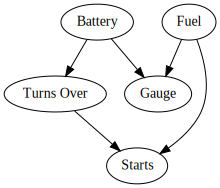

In [5]:
q5 = Digraph()
q5.node('b', 'Battery')
q5.node('g', 'Gauge')
q5.node('f', 'Fuel')
q5.node('t', 'Turns Over')
q5.node('s', 'Starts')
q5.edges(['bg','fg','bt','ts','fs'])
q5

In [6]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

In [7]:
# Create model from list of edges
model = BayesianModel([('B','G'),('F','G'),('B','T'),('T','S'),('F','S')])

# define p(B) and p(M) 
# variable_card is cardinality = 2 for true|false
# values are defined in numeric order p(x_i = [false, true]), ie  [0, 1]
priorB = TabularCPD(variable='B', variable_card=2, values=[[0.02, 0.98]])
priorF = TabularCPD(variable='F', variable_card=2, values=[[0.05, 0.95]])

# define p(G|B,F)
# Variables cycle in numerical order of evidence values,
# ie BF = 00, 01, 10, 11 for each value of G.
cpdG = TabularCPD(variable='G', variable_card=2, 
                  evidence=['B', 'F'], evidence_card=[2, 2],
                  values=[[0.99, 0.1, 0.97, 0.04], 
                          [0.01, 0.9, 0.03, 0.96]])

# define p(T|B)
cpdT = TabularCPD(variable='T', variable_card=2,
                 evidence=['B'], evidence_card=[2],
                 values=[[0.98, 0.03],
                         [0.02, 0.97]])

# define p(S|T,F)
cpdS = TabularCPD(variable='S', variable_card=2, 
                  evidence=['T', 'F'], evidence_card=[2, 2],
                  values=[[0.99, 1.0, 0.92, 0.01], 
                          [0.01, 0.0, 0.08, 0.99]])

# add probabilities to model
model.add_cpds(priorB, priorF, cpdG, cpdT, cpdS)
model.check_model()

True

In [8]:
inference = VariableElimination(model)
print(inference.query(['F'], evidence={'S' : 0}))

Eliminating: T: 100%|██████████| 3/3 [00:00<00:00, 278.67it/s]

+------+----------+
| F    |   phi(F) |
+======+==========+
| F(0) |   0.4537 |
+------+----------+
| F(1) |   0.5463 |
+------+----------+


Using my `pgmpy` model, I can see that my calculated probability is correct,
$$p(f=0|s=0) = 45.37\%$$

5.3 (10 pts) Suppose you have loaned this car to a friend. They call call you and announce, "the car won't start".  Illustrate your diagnostic and inference process by using the model to show how your beliefs change as you ask questions.  Your friend can only tell you the states of $t$ and $g$ (and you already know $s$).  Use two different scenarios, i.e. two different reasons why the car won't start.  For each scenario, your answer should discuss your choice of each question you pose to the network, and how it allows you to uncover the true cause the problem.

#### Scenario 1: Out of Gas

Our friend calls, saying that the car won't start. If we naively use the inference engine without asking any questions, we will get the following results:

In [9]:
print('p(f|s=0)')
print(inference.query(['F'], evidence={'S': 0}))
print('p(b|s=0)')
print(inference.query(['B'], evidence={'S': 0}))

Eliminating: F: 100%|██████████| 3/3 [00:00<00:00, 119.89it/s]

p(f|s=0)
+------+----------+
| F    |   phi(F) |
+======+==========+
| F(0) |   0.4537 |
+------+----------+
| F(1) |   0.5463 |
+------+----------+
p(b|s=0)
+------+----------+
| B    |   phi(B) |
+======+==========+
| B(0) |   0.1927 |
+------+----------+
| B(1) |   0.8073 |
+------+----------+


From these initial results, we see that it is more likely (45% vs 19%) that the car is out of gas. So we ask our friend to check the reading on the gauge, and they report that when they turn the key that the gauge reads empty. If we add this information into our inference engine, we see that it is extremely likely (93%) that the car is indeed out of gas.

In [10]:
print('p(f|s=0,g=0)')
print(inference.query(['F'], evidence={'S': 0, 'G': 0}))
print('p(b|s=0,g=0)')
print(inference.query(['B'], evidence={'S': 0, 'G': 0}))

Eliminating: B:   0%|          | 0/2 [00:00<?, ?it/s]

p(f|s=0,g=0)


Eliminating: B: 100%|██████████| 2/2 [00:00<00:00, 182.81it/s]

+------+----------+
| F    |   phi(F) |
+======+==========+
| F(0) |   0.9306 |
+------+----------+
| F(1) |   0.0694 |
+------+----------+
p(b|s=0,g=0)



Eliminating: F: 100%|██████████| 2/2 [00:00<00:00, 372.58it/s]

+------+----------+
| B    |   phi(B) |
+======+==========+
| B(0) |   0.0590 |
+------+----------+
| B(1) |   0.9410 |
+------+----------+


#### Scenario 2: Dead Battery
Our friend calls, saying that the car won't start. Using our prior experience we're slightly more likely to be out of gas than to have a dead battery, so we ask our friend to check the reading on the gauge. Our friend then tells us that the gauge is still working. Using this information, we still aren't certain about what is the cause of our problem.

In [11]:
print('p(f|s=0,g=1)')
print(inference.query(['F'], evidence={'S': 0, 'G': 1}))
print('p(b|s=0,g=1)')
print(inference.query(['B'], evidence={'S': 0, 'G': 1}))

Eliminating: F: 100%|██████████| 2/2 [00:00<00:00, 283.80it/s]

p(f|s=0,g=1)
+------+----------+
| F    |   phi(F) |
+======+==========+
| F(0) |   0.0255 |
+------+----------+
| F(1) |   0.9745 |
+------+----------+
p(b|s=0,g=1)
+------+----------+
| B    |   phi(B) |
+======+==========+
| B(0) |   0.3128 |
+------+----------+
| B(1) |   0.6872 |
+------+----------+


While it is now extremely unlikely that we're out of gas (2.5%), we still do not have much information about the state of the battery (31%). We ask our friend if the car turns over, and they inform us that it does not. Using our inference engine, we see that given this information that while the liklihood that it is the battery hasn't increased much (38% vs 31%). However the liklihood that we are out of gas is an order of magnitude lower than it was (0.12% vs 2.5%), so we can be fairly certain that the battery is dead.

In [12]:
print('p(f|s=0,t=0,g=0)')
print(inference.query(['F'], evidence={'S': 0, 'T': 0, 'G': 1}))
print('p(b|s=0,t=0,g=0)')
print(inference.query(['B'], evidence={'S': 0, 'T': 0, 'G': 1}))

Finding Elimination Order: : 100%|██████████| 1/1 [00:00<00:00, 234.38it/s]

p(f|s=0,t=0,g=0)



Eliminating: B: 100%|██████████| 1/1 [00:00<00:00, 164.22it/s]


+------+----------+
| F    |   phi(F) |
+======+==========+
| F(0) |   0.0012 |
+------+----------+
| F(1) |   0.9988 |
+------+----------+
p(b|s=0,t=0,g=0)


Eliminating: F: 100%|██████████| 1/1 [00:00<00:00, 190.59it/s]

+------+----------+
| B    |   phi(B) |
+======+==========+
| B(0) |   0.3844 |
+------+----------+
| B(1) |   0.6156 |
+------+----------+


For both of these scenarios, we initially assumed that the gas was empty, so we asked our friend to look at the gauge. However the gauge is affected by both the gas and the battery, so our liklihoods aren't super strong from that information. This led to having to ask a followup question to diagnose the dead battery. If we instead start by asking about whether the car turns over, we see that if it turns over we can guarantee that the battery isn't dead with high certainty (99%), and that it is probably the gas (83%). If the car doesn't turn over, our liklihoods aren't super certain, but it is almost 10x more likely to be the battery than the gas (40% vs 5%).

In [13]:
print('p(f|s=0,t=0)')
print(inference.query(['F'], evidence={'S': 0, 'T': 0}))
print('p(b|s=0,t=0)')
print(inference.query(['B'], evidence={'S': 0, 'T': 0}))
print('p(f|s=0,t=1)')
print(inference.query(['F'], evidence={'S': 0, 'T': 1}))
print('p(b|s=0,t=1)')
print(inference.query(['B'], evidence={'S': 0, 'T': 1}))

Eliminating: F: 100%|██████████| 2/2 [00:00<00:00, 415.44it/s]

p(f|s=0,t=0)
+------+----------+
| F    |   phi(F) |
+======+==========+
| F(0) |   0.0495 |
+------+----------+
| F(1) |   0.9505 |
+------+----------+
p(b|s=0,t=0)
+------+----------+
| B    |   phi(B) |
+======+==========+
| B(0) |   0.4000 |
+------+----------+
| B(1) |   0.6000 |
+------+----------+
p(f|s=0,t=1)



  0%|          | 0/2 [00:00<?, ?it/s]

+------+----------+
| F    |   phi(F) |
+======+==========+
| F(0) |   0.8288 |
+------+----------+
| F(1) |   0.1712 |
+------+----------+
p(b|s=0,t=1)


Eliminating: F: 100%|██████████| 2/2 [00:00<00:00, 111.26it/s]

+------+----------+
| B    |   phi(B) |
+======+==========+
| B(0) |   0.0004 |
+------+----------+
| B(1) |   0.9996 |
+------+----------+
